> ## <span style="font-size:34px; color:#00b8d4; vertical-align:middle;">&#128196;</span> <strong style="color:#00b8d4; font-size:28px;">Build Reference Table</strong>
> <span style="color:#757575; font-size:14px; display:block; margin-top:4px;">build a geospatial reference table for subsequent climate collation</span>
> <br/>
> <strong style="color:#37474f;">Description:</strong> 
> <br/><br/>
> <strong>Authors:</strong> Frederick Bennett &nbsp;&nbsp; <strong>Date:</strong> 21-08-2025 &nbsp;&nbsp; <strong>Version:</strong> 0.5
> <br/><br/>
> <strong>Kernel / Env:</strong> 
> <br/><br/>
> <strong>Status:</strong> 
> <br/><br/>
> <strong>Run instructions:</strong> This script uses two shapefiles to produce a CSV table that looks like this
> <br/>
> 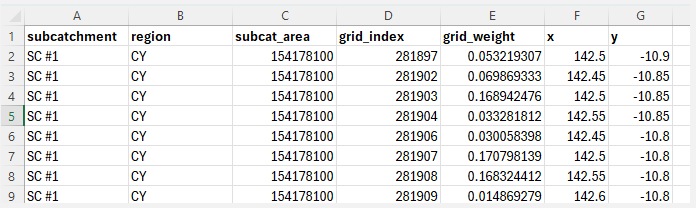 <br/><br/>
> All the geospatial data is transformed to **EPSG:3577** which is a coordinate reference system (CRS) code that represents the **Australian Albers Equal Area Conic projection**. This projection is designed to minimize distortion of area, making it particularly useful for mapping and spatial analysis in Australia. This CRS seems to be the one that [SILO](https://www.longpaddock.qld.gov.au/silo/) uses for its gridded data. 
> <br/><br/>
> <strong>Contact:</strong> frederick.bennett@detsi.qld.gov.au
> <br/><br/>
> 

In [1]:

import pandas as pd
import geopandas as gpd


In [2]:
#climate_grid = 'E:/My Drive/Work Projects/Climate_Collation_Script/shapefiles/climate_grid/Fishnet_AUS_ClimateGrid.shp'
#subcatchments = 'E:/My Drive/Work Projects/Climate_Collation_Script/shapefiles/GBR_Subcats/Catchment_Shp/'


climate_grid = 'D:/gdrive/My Drive/Work Projects/Climate_Collation_Script/shapefiles/climate_grid/Fishnet_AUS_ClimateGrid.shp'
subcatchments = 'D:/gdrive/My Drive/Work Projects/Climate_Collation_Script/shapefiles/GBR_Subcats/Catchment_Shp/'


In [5]:
climate_grid_df = gpd.read_file(climate_grid)
current_crs = climate_grid_df.crs
print('CRS for shapefile ', climate_grid_df.crs)

if climate_grid_df.crs != "EPSG:3577" :
    print('The climate grid shapefile has to be transposed to EPSG:3577' )
    climate_grid_trans = climate_grid_df.to_crs("EPSG:3577")
    print('Completed conversion to ',climate_grid_trans.crs)

CRS for shapefile  EPSG:4326
The climate grid shapefile has to be transposed to EPSG:3577
Completed conversion to  EPSG:3577


In [10]:
region = 'BM'

region_shp = subcatchments + region + '/Catchmt.shp'

region_shp

'E:/My Drive/Work Projects/Climate_Collation_Script/shapefiles/GBR_Subcats/Catchment_Shp/BM/Catchmt.shp'

In [19]:
subcatchments_df['region'] = region

In [20]:
subcatchments_df

,Catchmt,geometry,region
0,SC #90650,"POLYGON ((1943278.631 -2730940.469, 1943338.63...",BM
1,SC #90653,"POLYGON ((1968448.631 -2739070.469, 1968628.63...",BM
2,SC #90651,"POLYGON ((1949488.631 -2742100.469, 1949488.63...",BM
3,SC #90652,"POLYGON ((1961428.631 -2745100.469, 1961488.63...",BM
4,SC #1,"POLYGON ((1949368.631 -2748760.469, 1949458.63...",BM
...,...,...,...
677,SC #511,"POLYGON ((2026498.631 -3049210.469, 2026498.63...",BM
678,SC #157,"POLYGON ((1927408.631 -3049540.469, 1927438.63...",BM
679,SC #681,"POLYGON ((2042728.631 -3051730.469, 2042788.63...",BM
680,SC #156,"POLYGON ((1932778.631 -3052660.469, 1932898.63...",BM


In [12]:
subcatchments_df = gpd.read_file(region_shp)
current_crs = subcatchments_df.crs
print('CRS for shapefile ', subcatchments_df.crs)

subcatchments_df = subcatchments_df.set_crs("EPSG:3577")


CRS for shapefile  None


In [6]:
def get_areas(subcatchment, region):
    dictionary_list = []
    subcat_idx = subcatchments_df.query("Catchmt == @subcatchment").index[0]

    sub = subcatchments_df.iloc[subcat_idx]['geometry'].buffer(0) 
    intersections = sub.intersects(climate_grid_trans['geometry'])

    sub_area = sub.area

    ref_areas = 0
    for i in intersections.index :
        if intersections[i] ==  True :
            record = {}
            the_intersection = sub.intersection(climate_grid_trans.iloc[i].geometry)
            ref_poly = climate_grid_trans.iloc[i].geometry
            area_prop = the_intersection.area/sub_area
            ref_areas += the_intersection.area
            xy = climate_grid_df.iloc[i].geometry.centroid

            record['subcatchment'] = subcatchment
            record['region'] = region
            record['subcat_area'] = sub_area
            
            record['grid_index'] = i
            record['grid_weight'] = area_prop
            record['x'] = xy.x
            record['y'] = xy.y
            

            dictionary_list.append(record)
    return dictionary_list

In [7]:
result_list = []

regions = ['BM', 'BU', 'FI', 'MW', 'CY', 'WT']
for region in regions:
    print('running process for ' + region)
    region_shp = subcatchments + region + '/Catchmt.shp'
    subcatchments_df = gpd.read_file(region_shp)
    current_crs = subcatchments_df.crs
    print('CRS for shapefile ', subcatchments_df.crs)

    subcatchments_df = subcatchments_df.set_crs("EPSG:3577")

    subcat_list = subcatchments_df['Catchmt'].to_list()
    
    for subcat in subcat_list :
        result_list += get_areas(subcat, region)

running process for BM
CRS for shapefile  None
running process for BU
CRS for shapefile  None
running process for FI
CRS for shapefile  None
running process for MW
CRS for shapefile  None
running process for CY
CRS for shapefile  None
running process for WT
CRS for shapefile  None


In [8]:
reference_table = pd.DataFrame(result_list)

In [9]:
reference_table.to_csv('reference_table.csv', index=False)

In [8]:
reference_table

,subcatchment,region,subcat_area,grid_index,grid_weight,x,y
0,SC #90650,BM,68811300.0,168776,0.037022,151.40,-24.10
1,SC #90650,BM,68811300.0,168777,0.058544,151.45,-24.10
2,SC #90650,BM,68811300.0,169545,0.270865,151.40,-24.05
3,SC #90650,BM,68811300.0,169546,0.062244,151.45,-24.05
4,SC #90650,BM,68811300.0,170311,0.046704,151.35,-24.00
...,...,...,...,...,...,...,...
46662,SC #388,WT,31701600.0,237147,0.321665,146.25,-18.95
46663,SC #388,WT,31701600.0,237148,0.124753,146.30,-18.95
46664,SC #388,WT,31701600.0,237643,0.243880,146.25,-18.90
46665,SC #388,WT,31701600.0,237644,0.306646,146.30,-18.90
